# Medical Image Analysis with Deep Learning

This notebook demonstrates the use of deep learning for medical image analysis, supporting both classification and regression tasks. The pipeline includes:

1. Image preprocessing
2. Dataset creation and data loading
3. Model architecture definition
4. Hyperparameter tuning
5. Model training and evaluation
6. Results visualization

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

from preprocessing import process_single_image, visualize_preprocessing, process_all_images
from dataset import MedicalImageDataset, create_data_loaders
from model import MedicalCNN, ModelTrainer
from hyperparameter_tuning import HyperparameterTuner

c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Configuration

Set up the configuration for the experiment. You can modify these parameters to experiment with different settings.

In [2]:
# Experiment configuration
config = {
    'task_type': 'classification',  # or 'regression'
    'num_classes': 2,  # for classification only
    'image_dir': './data/after_processed',
    'labels_file': './data/labels.csv',
    'batch_size': 32,
    'num_epochs': 2,
    'learning_rate': 0.001,
    'train_ratio': 0.5,
    'val_ratio': 0.25,
    'test_ratio': 0.25,
    'random_seed': 42,
    'save_dir': './results',
    
    # Grid search parameters
    'grid_search': {
        'num_conv_layers': [3, 4],
        'conv_channels': [32, 64],
        'fc_layers': [[512, 128], [256, 64]],  # , [1024, 256, 64]
        'learning_rate': [0.001] # , 0.0001
    }
}

## Data Preprocessing

Let's visualize the preprocessing steps on a sample image.

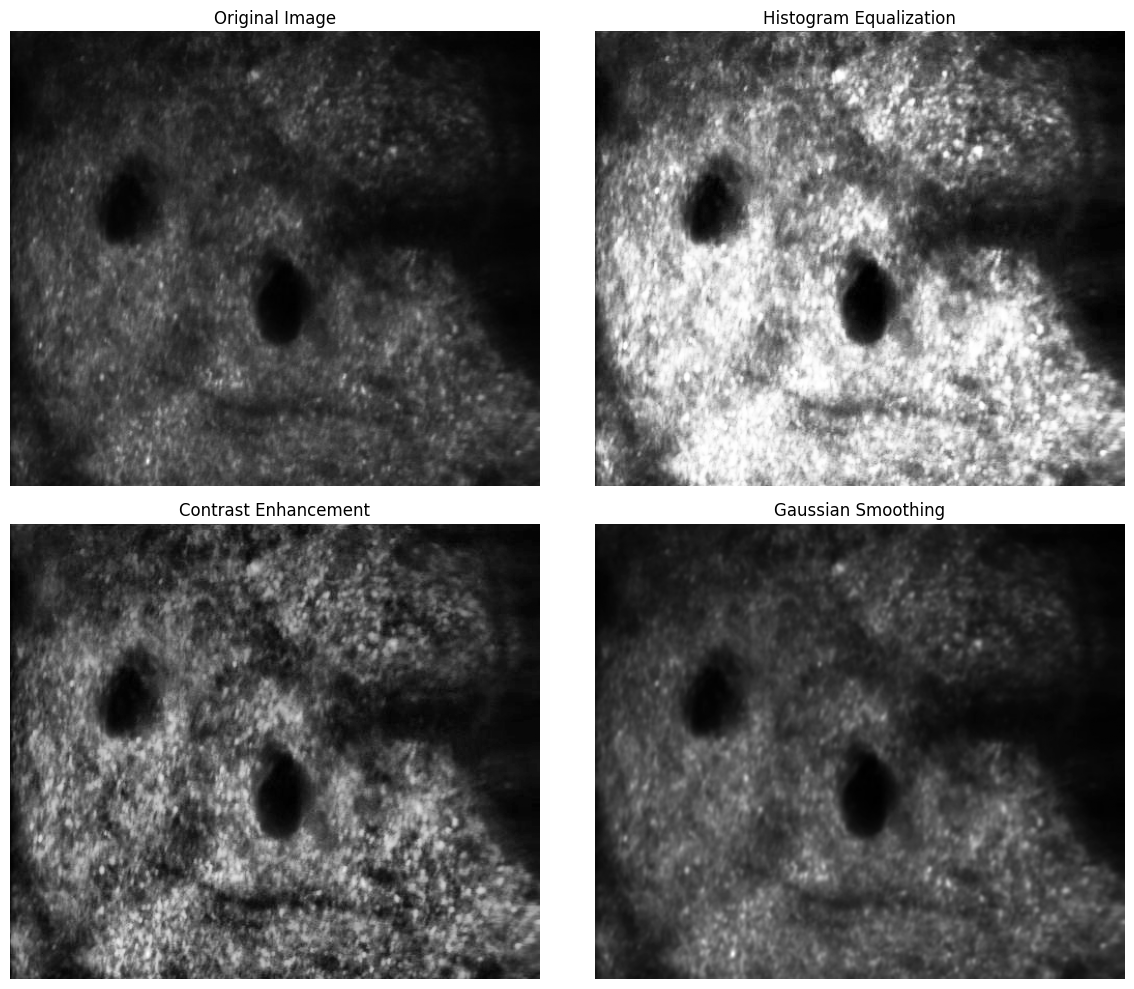

In [3]:
# Visualize preprocessing on a sample image
sample_image_path = list(Path('./data/ori_images').glob('*.png'))[0]
visualize_preprocessing(sample_image_path)

Now, let's process all images in the dataset:

In [4]:
# Process all images
input_dir = './data/ori_images'
output_dir = config['image_dir']
target_size = (224, 224)  # Standard size for many CNN architectures

process_all_images(input_dir, output_dir, target_size)

## Data Loading

Create data loaders for training, validation, and testing.

In [5]:
# Create data loaders
data_loaders = create_data_loaders(
    data_dir=config['image_dir'],
    labels_file=config['labels_file'],
    task_type=config['task_type'],
    batch_size=config['batch_size'],
    train_ratio=config['train_ratio'],
    val_ratio=config['val_ratio'],
    test_ratio=config['test_ratio'],
    random_seed=config['random_seed']
)
train_loader, val_loader, test_loader = data_loaders['train'], data_loaders['val'], data_loaders['test']

# Print dataset sizes
print(f"Training set size: {len(data_loaders['train'].dataset)}")
print(f"Validation set size: {len(data_loaders['val'].dataset)}")
print(f"Test set size: {len(data_loaders['test'].dataset)}")

Training set size: 5
Validation set size: 2
Test set size: 3


## Grid Search

Perform grid search to find the best model architecture and hyperparameters.

In [6]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize hyperparameter tuner
tuner = HyperparameterTuner(
    train_loader=train_loader,
    val_loader=val_loader,
    task_type=config['task_type'],
    num_classes=config['num_classes'],
    device=device,
    save_dir=Path(config['save_dir']) / 'grid_search'
)

# Perform grid search
grid_search_results = tuner.grid_search(
    param_grid=config['grid_search'],
    num_epochs=config['num_epochs']
)

# Plot results
tuner.plot_results()

# Print best combination
print('\nBest combination:')
print(json.dumps(grid_search_results['best_combination'], indent=2))
print('\nBest validation metrics:')
print(json.dumps(grid_search_results['best_val_metrics'], indent=2))

Using device: cpu

Trying combination 1/8:
{
  "num_conv_layers": 3,
  "conv_channels": 32,
  "fc_layers": [
    512,
    128
  ],
  "learning_rate": 0.001
}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/2]
Train Loss: 0.6830, Train Metrics: {'accuracy': 0.8, 'precision': 1.0, 'recall': 0.8, 'f1': 0.888888888888889}
Val Loss: 2.2934, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/2]
Train Loss: 0.1381, Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Val Loss: 8.9325, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

Trying combination 2/8:
{
  "num_conv_layers": 3,
  "conv_channels": 32,
  "fc_layers": [
    256,
    64
  ],
  "learning_rate": 0.001
}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/2]
Train Loss: 0.6935, Train Metrics: {'accuracy': 0.6, 'precision': 1.0, 'recall': 0.6, 'f1': 0.75}
Val Loss: 1.0272, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/2]
Train Loss: 0.4353, Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Val Loss: 2.0391, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

Trying combination 3/8:
{
  "num_conv_layers": 3,
  "conv_channels": 64,
  "fc_layers": [
    512,
    128
  ],
  "learning_rate": 0.001
}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/2]
Train Loss: 0.7618, Train Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Val Loss: 4.7242, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/2]
Train Loss: 0.0167, Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Val Loss: 23.3416, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

Trying combination 4/8:
{
  "num_conv_layers": 3,
  "conv_channels": 64,
  "fc_layers": [
    256,
    64
  ],
  "learning_rate": 0.001
}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/2]
Train Loss: 0.7460, Train Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Val Loss: 1.8762, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/2]
Train Loss: 0.2324, Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Val Loss: 9.8701, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

Trying combination 5/8:
{
  "num_conv_layers": 4,
  "conv_channels": 32,
  "fc_layers": [
    512,
    128
  ],
  "learning_rate": 0.001
}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/2]
Train Loss: 0.6861, Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Val Loss: 1.0577, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/2]
Train Loss: 0.4429, Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Val Loss: 2.7247, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

Trying combination 6/8:
{
  "num_conv_layers": 4,
  "conv_channels": 32,
  "fc_layers": [
    256,
    64
  ],
  "learning_rate": 0.001
}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/2]
Train Loss: 0.7758, Train Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Val Loss: 0.8003, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/2]
Train Loss: 0.5733, Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Val Loss: 1.5475, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

Trying combination 7/8:
{
  "num_conv_layers": 4,
  "conv_channels": 64,
  "fc_layers": [
    512,
    128
  ],
  "learning_rate": 0.001
}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/2]
Train Loss: 0.6874, Train Metrics: {'accuracy': 0.4, 'precision': 1.0, 'recall': 0.4, 'f1': 0.5714285714285714}
Val Loss: 1.2884, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/2]
Train Loss: 0.2851, Train Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Val Loss: 7.1454, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

Trying combination 8/8:
{
  "num_conv_layers": 4,
  "conv_channels": 64,
  "fc_layers": [
    256,
    64
  ],
  "learning_rate": 0.001
}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/2]
Train Loss: 0.7404, Train Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
Val Loss: 0.7505, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Haoyu\anaconda3\envs\YP_scholar\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/2]
Train Loss: 0.6890, Train Metrics: {'accuracy': 0.6, 'precision': 1.0, 'recall': 0.6, 'f1': 0.75}
Val Loss: 1.4767, Val Metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

Best combination:
{
  "num_conv_layers": 4,
  "conv_channels": 64,
  "fc_layers": [
    256,
    64
  ],
  "learning_rate": 0.001
}

Best validation metrics:
{
  "accuracy": 0.0,
  "precision": 0.0,
  "recall": 0.0,
  "f1": 0.0
}


## Train Best Model

Train the model with the best hyperparameters found during grid search.

In [6]:
# Get best parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

grid_search_res_path = 'results\grid_search\grid_search_summary.json'
with open(grid_search_res_path, 'r') as f:
    grid_search_results = json.load(f)

best_params = grid_search_results['best_combination']

# Create model with best parameters
model = MedicalCNN(
    task_type=config['task_type'],
    num_classes=config['num_classes'],
    num_conv_layers=best_params['num_conv_layers'],
    conv_channels=best_params['conv_channels'],
    fc_layers=best_params['fc_layers']
)

# Define loss function and optimizer
if config['task_type'] == 'classification':
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

# Initialize trainer
trainer = ModelTrainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    task_type=config['task_type']
)

# Check if best model exists, if so, load it; otherwise, train and save
from pathlib import Path
best_model_path = Path(config['save_dir']) / 'best_model' / 'best_model.pth'
if best_model_path.exists():
    print(f"Found existing best model at {best_model_path}, loading...")
    trainer.load_model(str(best_model_path))
    history = None  # No new training history
else:
    print("No existing best model found, training...")
    history = trainer.train(
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=config['num_epochs'],
        save_dir=Path(config['save_dir']) / 'best_model',
        early_stopping_patience=5
    )
    # Plot training history
    trainer.plot_training_history(Path(config['save_dir']) / 'best_model')

# Set class names for classification tasks
if config['task_type'] == 'classification':
    # Define class name mapping
    class_names = {0: 'Normal', 1: 'Abnormal'}  # Modify according to your specific classes
    # Or you can set it according to your needs, for example:
    # class_names = {0: 'aa', 1: 'bb'}
    
    # Set class names to trainer
    trainer.set_class_names(class_names)
    print(f"Class names set: {class_names}")

# Save the trainer state for later use
best_trainer = trainer

Using device: cpu
Found existing best model at results\best_model\best_model.pth, loading...
Class names set: {0: 'Normal', 1: 'Abnormal'}


## Evaluation

Evaluate the best model on the test set.

In [9]:
# Evaluate on test set
print("Evaluating model on test set...")
test_metrics = trainer.evaluate(test_loader, Path(config['save_dir']) / 'best_model')
print('\nTest Set Metrics:')
print(json.dumps(test_metrics, indent=2))

# Print some debug information
print(f"\nModel device: {next(trainer.model.parameters()).device}")
print(f"Task type: {trainer.task_type}")
print(f"Test set size: {len(test_loader.dataset)}")

Evaluating model on test set...

Test Set Metrics:
{
  "accuracy": 0.0,
  "precision": 0.0,
  "recall": 0.0,
  "f1": 0.0
}

Model device: cpu
Task type: classification
Test set size: 3


In [8]:
# Performance comparison with traditional machine learning methods
print("="*60)
print("STARTING MODEL COMPARISON WITH TRADITIONAL ML METHODS")
print("="*60)

# Import required modules for comparison
from model import compare_models_performance

# DEBUG CONTROL - Set to True for detailed debugging information
DEBUG_MODE = False  # Change to True if you want to see detailed debug information

# Set class names for comparison (if classification task)
comparison_class_names = None
if config['task_type'] == 'classification':
    comparison_class_names = {0: 'Normal', 1: 'Abnormal'}  # Modify according to your classes

print(f"Configuration:")
print(f"  Task type: {config['task_type']}")
print(f"  Train set size: {len(train_loader.dataset)}")
print(f"  Validation set size: {len(val_loader.dataset)}")
print(f"  Test set size: {len(test_loader.dataset)}")
print(f"  Class names: {comparison_class_names}")
print(f"  Debug mode: {DEBUG_MODE}")
print(f"  Save directory: ./results/model_evaluation")

try:
    # Compare models performance
    comparison_results = compare_models_performance(
        best_cnn_trainer=trainer,
        train_loader=train_loader,
        val_loader=val_loader, 
        test_loader=test_loader,
        save_dir='./results/model_evaluation',
        task_type=config['task_type'],
        class_names=comparison_class_names,
        debug=DEBUG_MODE  # Control debug output
    )

    # Display comparison results
    print("\n" + "="*50)
    print("MODEL PERFORMANCE COMPARISON RESULTS")
    print("="*50)

    for model_name, metrics in comparison_results.items():
        print(f"\n{model_name}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name.upper()}: {value:.4f}")

    print(f"\nAll comparison plots saved to: ./results/model_evaluation/")
    print("Generated files:")
    if config['task_type'] == 'classification':
        print("- aupr_comparison.png (AUPR curves)")
        print("- auc_comparison.png (ROC curves)")
        print("- accuracy_comparison.png")
        print("- precision_comparison.png") 
        print("- recall_comparison.png")
        print("- f1_comparison.png")
    else:
        print("- mse_comparison.png")
        print("- mae_comparison.png")
        print("- r2_comparison.png")
    print("- model_comparison_results.json")
    
except Exception as e:
    print(f"Error during model comparison: {e}")
    if DEBUG_MODE:
        import traceback
        traceback.print_exc()

STARTING MODEL COMPARISON WITH TRADITIONAL ML METHODS
Configuration:
  Task type: classification
  Train set size: 5
  Validation set size: 2
  Test set size: 3
  Class names: {0: 'Normal', 1: 'Abnormal'}
  Debug mode: False
  Save directory: ./results/model_evaluation
Model comparison results saved to ./results/model_evaluation

MODEL PERFORMANCE COMPARISON RESULTS

Deep Learning (CNN):
  ACCURACY: 0.0000
  PRECISION: 0.0000
  RECALL: 0.0000
  F1: 0.0000

Random Forest:
  ACCURACY: 0.0000
  PRECISION: 0.0000
  RECALL: 0.0000
  F1: 0.0000

SVM:
  ACCURACY: 0.0000
  PRECISION: 0.0000
  RECALL: 0.0000
  F1: 0.0000

Logistic Regression:
  ACCURACY: 0.0000
  PRECISION: 0.0000
  RECALL: 0.0000
  F1: 0.0000

All comparison plots saved to: ./results/model_evaluation/
Generated files:
- aupr_comparison.png (AUPR curves)
- auc_comparison.png (ROC curves)
- accuracy_comparison.png
- precision_comparison.png
- recall_comparison.png
- f1_comparison.png
- model_comparison_results.json
